In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
import pandas as pd
import plotly.express as px

In [2]:
sns.set()

In [3]:
drowings = np.loadtxt("../data/drowning.txt")
drowings;

In [4]:
data = np.loadtxt("../data/factory.txt")
data

array([[ 83., 117., 101., 105.,  79.,  57.],
       [ 92., 109.,  93., 119.,  97.,  92.],
       [ 92., 114.,  92., 116., 103., 104.],
       [ 46., 104.,  86., 102.,  79.,  77.],
       [ 67.,  87.,  67., 116.,  92., 100.]])

## Pooled model

\begin{align*}
y_{ij} &\sim \mathcal{N}(\mu, \sigma) \\
\mu &\sim \mathcal{N}(92, 100) \\
\sigma &\sim |\mathcal{N}|(0, 100) \\
\end{align*}


In [5]:
data_vec = data.ravel()
data_vec

array([ 83., 117., 101., 105.,  79.,  57.,  92., 109.,  93., 119.,  97.,
        92.,  92., 114.,  92., 116., 103., 104.,  46., 104.,  86., 102.,
        79.,  77.,  67.,  87.,  67., 116.,  92., 100.])

In [6]:
pd.Series(data_vec).describe()

count     30.000000
mean      92.933333
std       18.001788
min       46.000000
25%       83.750000
50%       92.500000
75%      104.000000
max      119.000000
dtype: float64

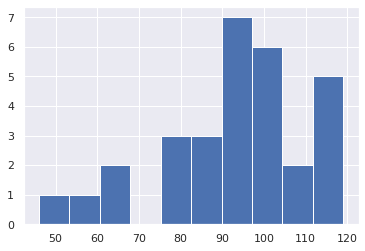

In [7]:
plt.hist(data_vec);

<AxesSubplot:>

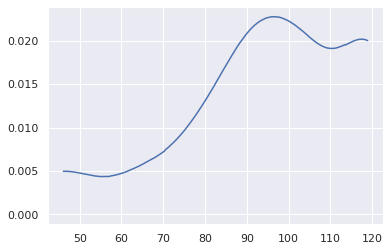

In [8]:
az.plot_kde(data_vec)

In [9]:
(120 - 92.5)/3

9.166666666666666

In [10]:
import scipy
pd.DataFrame(scipy.stats.halfnorm.rvs(size=1000, scale=15)).describe()

0
count  1000.000000
mean     11.654954
std       8.847752
min       0.034751
25%       4.840607
50%       9.788146
75%      16.451363
max      55.171451

In [11]:
with pm.Model() as factory_pooled:
    mu = pm.Normal('mu', mu=92.5, sd=10)
    std = pm.HalfNormal('std', sd=15)
    y = pm.Normal('y', mu=mu, sd=std, observed=data_vec)
    trace_pooled = pm.sample(10_000)

/tmp/ipykernel_10423/3746291418.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_pooled = pm.sample(10_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 7 seconds.


In [12]:
az.summary(trace_pooled)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu   92.924  3.191  86.872   98.905      0.017    0.012   34211.0   26617.0   
std  18.241  2.387  14.140   22.848      0.014    0.010   31078.0   26292.0   

     r_hat  
mu     1.0  
std    1.0

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'mu'}>,
       <AxesSubplot:title={'center':'std'}>], dtype=object)

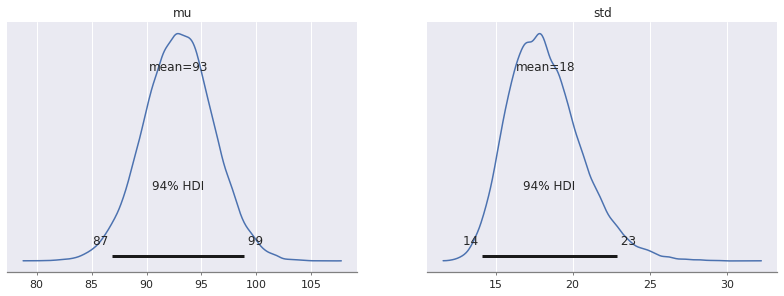

In [13]:
az.plot_posterior(trace_pooled)

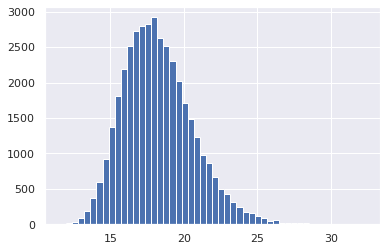

In [14]:
plt.hist(trace_pooled["std"], bins=50);

In [15]:
#with factory_pooled:
az.waic(trace_pooled)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 40000 posterior samples and 30 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -130.78     4.39
p_waic        1.95        -

There has been a warning during the calculation. Please check the results.

## Separate model

\begin{align*}
y_{ij} &\sim \mathcal{N}(\mu_j, \sigma_j) \\
\mu_{j} &\sim \mathcal{N}(0, 1) \\
\sigma_{j} &\sim |\mathcal{N}|(0, \sigma_j) \\
\end{align*}



In [16]:
#data.ravel(order="F")
#np.tile(np.arange(groups), meas)

groups = data.shape[1] # number of groups
meas = data.shape[0] # number of measurements per group
data_vec = data.ravel()
group_vec = np.tile(np.arange(groups), meas)

In [17]:
data_vec

array([ 83., 117., 101., 105.,  79.,  57.,  92., 109.,  93., 119.,  97.,
        92.,  92., 114.,  92., 116., 103., 104.,  46., 104.,  86., 102.,
        79.,  77.,  67.,  87.,  67., 116.,  92., 100.])

In [18]:
group_vec

array([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
       4, 5, 0, 1, 2, 3, 4, 5])

In [19]:
data.mean(axis=0)

array([ 76. , 106.2,  87.8, 111.6,  90. ,  86. ])

In [20]:
data.std(axis=0, ddof=1)

array([19.63415392, 11.81947545, 12.79453008,  7.56967635, 10.77032961,
       19.22238279])

In [21]:
with pm.Model() as factory_separate:
    group_mu = pm.Normal('group_mu', mu=92.5, sd=100, shape=groups)
    group_std = pm.HalfNormal('group_std', sd=100, shape=groups)
    y = pm.Normal('y', mu=group_mu[group_vec], sd=group_std[group_vec], observed=data_vec)
    trace_separate = pm.sample(10_000)


/tmp/ipykernel_10423/1392549784.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace_separate = pm.sample(10_000)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [group_std, group_mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 13 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


In [22]:
az.summary(trace_separate)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
group_mu[0]    76.415  14.759   48.847  104.008      0.142    0.110   16180.0   
group_mu[1]   106.116   9.370   88.598  123.128      0.088    0.067   19201.0   
group_mu[2]    87.843   9.888   69.218  106.408      0.078    0.055   21567.0   
group_mu[3]   111.513   6.101  101.050  123.453      0.056    0.039   17900.0   
group_mu[4]    90.041   8.506   74.155  105.502      0.074    0.053   20203.0   
group_mu[5]    86.044  13.891   60.750  112.948      0.118    0.089   18120.0   
group_std[0]   29.253  15.987   10.337   56.422      0.136    0.102   21512.0   
group_std[1]   18.102  10.877    6.098   35.556      0.095    0.072   22360.0   
group_std[2]   19.654  11.559    6.507   38.463      0.093    0.066   21923.0   
group_std[3]   11.834   7.595    3.987   23.752      0.068    0.048   21686.0   
group_std[4]   16.610   9.971    5.574   32.889      0.090    0.068   21270.0   
group_std[5]   28.336  15.087    9.955   54.165      0.125    0.091   20281.0   

              ess_tail  r_hat  
group_mu[0]    13652.0    1.0  
group_mu[1]    14318.0    1.0  
group_mu[2]    15885.0    1.0  
group_mu[3]    13093.0    1.0  
group_mu[4]    15691.0    1.0  
group_mu[5]    14657.0    1.0  
group_std[0]   15372.0    1.0  
group_std[1]   15799.0    1.0  
group_std[2]   16698.0    1.0  
group_std[3]   15644.0    1.0  
group_std[4]   16305.0    1.0  
group_std[5]   17408.0    1.0

In [23]:
#plt.hist(trace_separate["group_std"][:, 5], bins=50);
px.histogram(trace_separate["group_std"][:, 5])#, bins=50);

<AxesSubplot:title={'center':'x'}>

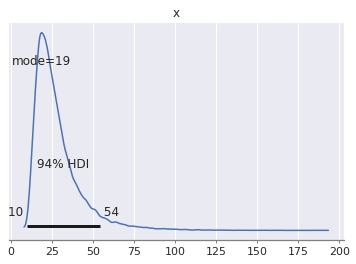

In [24]:
az.plot_posterior(trace_separate["group_std"][:, 5], point_estimate='mode')

<AxesSubplot:title={'center':'x'}>

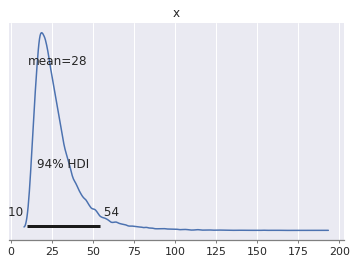

In [25]:
az.plot_posterior(trace_separate["group_std"][:, 5], point_estimate='mean')

In [26]:
az.summary(trace_separate)

Got error No model on context stack. trying to find log_likelihood in translation.
/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning:

Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.



mean      sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
group_mu[0]    76.415  14.759   48.847  104.008      0.142    0.110   16180.0   
group_mu[1]   106.116   9.370   88.598  123.128      0.088    0.067   19201.0   
group_mu[2]    87.843   9.888   69.218  106.408      0.078    0.055   21567.0   
group_mu[3]   111.513   6.101  101.050  123.453      0.056    0.039   17900.0   
group_mu[4]    90.041   8.506   74.155  105.502      0.074    0.053   20203.0   
group_mu[5]    86.044  13.891   60.750  112.948      0.118    0.089   18120.0   
group_std[0]   29.253  15.987   10.337   56.422      0.136    0.102   21512.0   
group_std[1]   18.102  10.877    6.098   35.556      0.095    0.072   22360.0   
group_std[2]   19.654  11.559    6.507   38.463      0.093    0.066   21923.0   
group_std[3]   11.834   7.595    3.987   23.752      0.068    0.048   21686.0   
group_std[4]   16.610   9.971    5.574   32.889      0.090    0.068   21270.0   
group_std[5]   28.336  15.087    9.955   54.165      0.125    0.091   20281.0   

              ess_tail  r_hat  
group_mu[0]    13652.0    1.0  
group_mu[1]    14318.0    1.0  
group_mu[2]    15885.0    1.0  
group_mu[3]    13093.0    1.0  
group_mu[4]    15691.0    1.0  
group_mu[5]    14657.0    1.0  
group_std[0]   15372.0    1.0  
group_std[1]   15799.0    1.0  
group_std[2]   16698.0    1.0  
group_std[3]   15644.0    1.0  
group_std[4]   16305.0    1.0  
group_std[5]   17408.0    1.0

## Hierarchical model, common std

\begin{align*}
y_{ij} &\sim \mathcal{N}(\mu_j, \sigma_j) \\
\mu_{j} &\sim \mathcal{N}(0, 1) \\
\sigma_{j} &\sim |\mathcal{N}|(0, \sigma_j) \\
\end{align*}



In [27]:
data.mean(axis=0)

array([ 76. , 106.2,  87.8, 111.6,  90. ,  86. ])

In [28]:
data.std()

17.699215299617727

In [29]:
with pm.Model() as factory_hierarchical:
    
    # hyper_priors
    hyper_mu_mu = pm.Normal('hyper_mu_mu', mu=92, sd=100)
    hyper_mu_std = pm.HalfNormal('hyper_mu_std', sd=100)

    # priors    
    group_mu = pm.Normal('group_mu', mu=hyper_mu_mu, sd=hyper_mu_std, shape=groups)
    std = pm.HalfNormal('std', sd=100)
    y = pm.Normal('y', mu=group_mu[group_vec], sd=std, observed=data_vec)
    trace_hierarchical = pm.sample(10_000, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [std, group_mu, hyper_mu_std, hyper_mu_mu]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 14 seconds.
There were 175 divergences after tuning. Increase `target_accept` or reparameterize.
There were 233 divergences after tuning. Increase `target_accept` or reparameterize.
There were 419 divergences after tuning. Increase `target_accept` or reparameterize.
There were 279 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [30]:
az.summary(trace_hierarchical)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
hyper_mu_mu    92.938  7.920  78.223  107.976      0.053    0.037   25152.0   
group_mu[0]    79.956  6.806  66.789   92.281      0.090    0.066    5865.0   
group_mu[1]   103.022  6.672  90.597  115.960      0.113    0.080    3713.0   
group_mu[2]    88.982  6.109  77.369  100.423      0.035    0.025   29220.0   
group_mu[3]   107.172  7.002  93.878  120.040      0.133    0.094    2968.0   
group_mu[4]    90.644  6.088  79.156  102.192      0.036    0.026   28337.0   
group_mu[5]    87.587  6.242  76.073   99.543      0.041    0.029   23094.0   
hyper_mu_std   15.910  9.366   2.786   30.899      0.125    0.088    1977.0   
std            15.228  2.370  11.125   19.647      0.030    0.021    7345.0   

              ess_tail  r_hat  
hyper_mu_mu    21393.0    1.0  
group_mu[0]     1539.0    1.0  
group_mu[1]     1151.0    1.0  
group_mu[2]    24440.0    1.0  
group_mu[3]      864.0    1.0  
group_mu[4]    20862.0    1.0  
group_mu[5]    17497.0    1.0  
hyper_mu_std     638.0    1.0  
std            16535.0    1.0

## Model selection 

In [31]:
with factory_hierarchical:
    display(az.waic(trace_hierarchical))

/home/marco/anaconda3/envs/bda/lib/python3.9/site-packages/arviz/stats/stats.py:1661: UserWarning:

For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details



Computed from 40000 posterior samples and 30 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -126.60     4.00
p_waic        5.44        -

There has been a warning during the calculation. Please check the results.

In [32]:
log_lik = np.array(trace_hierarchical.log_likelihood.y) # chains, iters, obs
log_lik = log_lik.reshape((-1, log_lik.shape[-1])) # mc samples, obs
S, ny = log_lik.shape

In [33]:
p_waic = np.var(log_lik, axis=0) # correct
p_waic = np.sum(p_waic)
p_waic

5.443531930391218

In [34]:
lppd = scipy.special.logsumexp(log_lik, axis=0) - np.log(S) # sum is equivalent to logsumexp in log domain...
lppd = np.sum(lppd)
lppd

-121.15642187297772

In [35]:
-2*(lppd - p_waic)

253.19990760673787

In [36]:
lppd - p_waic

-126.59995380336893

In [37]:
az.waic?

In [38]:
import pandas as pd
df = pd.DataFrame(data)
df.index.name = "measuremet"
df.columns = ["F1", "F2", "F3", "F4", "F5", "F6"]
df.columns.name = "factory"
df.to_csv("factory.csv")

factory       F1     F2     F3     F4     F5     F6
measuremet                                         
0           83.0  117.0  101.0  105.0   79.0   57.0
1           92.0  109.0   93.0  119.0   97.0   92.0
2           92.0  114.0   92.0  116.0  103.0  104.0
3           46.0  104.0   86.0  102.0   79.0   77.0
4           67.0   87.0   67.0  116.0   92.0  100.0

In [39]:
df.agg(["mean", "std"])

factory         F1          F2        F3          F4        F5         F6
mean     76.000000  106.200000  87.80000  111.600000  90.00000  86.000000
std      19.634154   11.819475  12.79453    7.569676  10.77033  19.222383

In [40]:
data.std(axis=0)

array([17.56132113, 10.57166023, 11.4437756 ,  6.77052435,  9.63327566,
       17.19302184])

In [41]:
data.mean(), data.std()

(92.93333333333334, 17.699215299617727)

In [42]:
az.summary(trace_hierarchical)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
hyper_mu_mu    92.938  7.920  78.223  107.976      0.053    0.037   25152.0   
group_mu[0]    79.956  6.806  66.789   92.281      0.090    0.066    5865.0   
group_mu[1]   103.022  6.672  90.597  115.960      0.113    0.080    3713.0   
group_mu[2]    88.982  6.109  77.369  100.423      0.035    0.025   29220.0   
group_mu[3]   107.172  7.002  93.878  120.040      0.133    0.094    2968.0   
group_mu[4]    90.644  6.088  79.156  102.192      0.036    0.026   28337.0   
group_mu[5]    87.587  6.242  76.073   99.543      0.041    0.029   23094.0   
hyper_mu_std   15.910  9.366   2.786   30.899      0.125    0.088    1977.0   
std            15.228  2.370  11.125   19.647      0.030    0.021    7345.0   

              ess_tail  r_hat  
hyper_mu_mu    21393.0    1.0  
group_mu[0]     1539.0    1.0  
group_mu[1]     1151.0    1.0  
group_mu[2]    24440.0    1.0  
group_mu[3]      864.0    1.0  
group_mu[4]    20862.0    1.0  
group_mu[5]    17497.0    1.0  
hyper_mu_std     638.0    1.0  
std            16535.0    1.0

In [43]:
import pandas as pd
df = pd.DataFrame(data)
df.index.name = "measuremet"
df.columns = ["F1", "F2", "F3", "F4", "F5", "F6"]
df.columns.name = "factory"
df

factory       F1     F2     F3     F4     F5     F6
measuremet                                         
0           83.0  117.0  101.0  105.0   79.0   57.0
1           92.0  109.0   93.0  119.0   97.0   92.0
2           92.0  114.0   92.0  116.0  103.0  104.0
3           46.0  104.0   86.0  102.0   79.0   77.0
4           67.0   87.0   67.0  116.0   92.0  100.0

In [44]:
df.agg(["mean", "std"])

factory         F1          F2        F3          F4        F5         F6
mean     76.000000  106.200000  87.80000  111.600000  90.00000  86.000000
std      19.634154   11.819475  12.79453    7.569676  10.77033  19.222383

In [45]:
data.std(axis=0)

array([17.56132113, 10.57166023, 11.4437756 ,  6.77052435,  9.63327566,
       17.19302184])

In [46]:
data.mean(), data.std()

(92.93333333333334, 17.699215299617727)

In [47]:
data.std(axis=0)

array([17.56132113, 10.57166023, 11.4437756 ,  6.77052435,  9.63327566,
       17.19302184])

In [48]:
data.mean(), data.std()

(92.93333333333334, 17.699215299617727)